# Demo:  Polynomial Model Order Selection

In this demo, we will illustrate the process of cross-validation for model order selection.  We demonstrate the concepts on synthetic data for a polynomial fit.  The lab will demonstrate how to:
* Characterize the model order for a simple polynomial model
* Measure training and test error for a given model order
* Select a suitable model order using cross-validation
* Plot the results for the model order selection process

We first load the packages as usual.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

## Polynomial Data

To illustrate the concepts, we consider a simple polynomial model:
$$
   y = \beta_0 + \beta_1 x + \cdots + \beta_d x^d + \epsilon,
$$
where $d$ is the polynomial degree.  We first generate synthetic data for this model.

In [3]:
# Import useful polynomial library
import numpy.polynomial.polynomial as poly

# True model parameters
beta = np.array([1,0.5,0,2])   # coefficients
wstd = 0.2                     # noise
dtrue = len(beta)-1            # true poly degree

# Independent data
nsamp = 40
xdat = np.random.uniform(-1,1,nsamp)

# Polynomial
y0 = poly.polyval(xdat,beta)
ydat = y0 + np.random.normal(0,wstd,nsamp)

If you were given the data, you would first plot the a scatter plot like this.

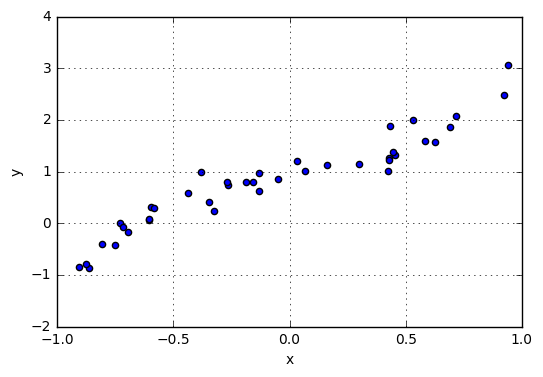

In [4]:
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

From this plot, you would have to find the relation $y \approx f(x)$.  In this case, since the data was generated synthetically, so we know "true" relation $y = f_0(x) + w$.    Let's plot the true relation on top of the scatter plot.  Of course, for "real" data, we would not know the true relation.  But, the synthetic data is useful to illustrate the concepts in the demo.  

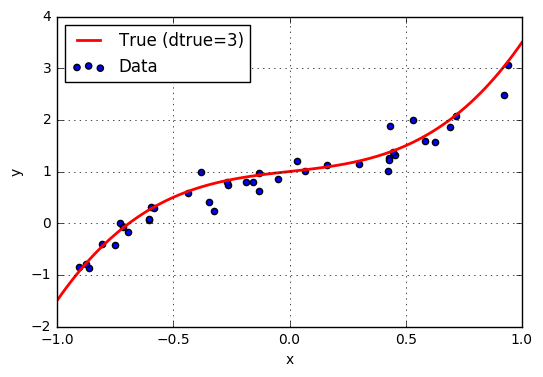

In [5]:
# Plot true function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=2.0)

# Plot the scatter plot of the measured data
plt.scatter(xdat,ydat)
plt.xlim([-1,1])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend(['True (dtrue=3)', 'Data'], loc='upper left')
plt.show()

## Fit Model of Different Model Orders
First, we try to fit a model with the correct model order `d=3`.  While we could set this up as a linear regression, we will directly yse the `polyfit` command.

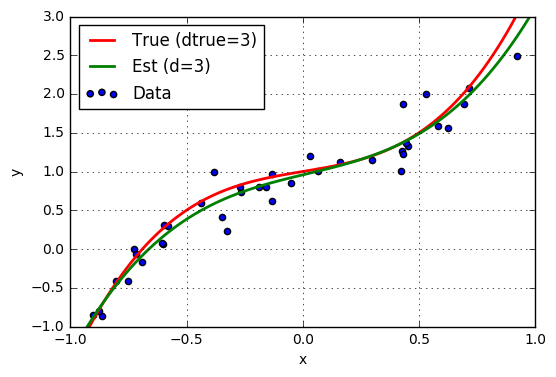

In [6]:
d = 3
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=2)
plt.plot(xp,yp_hat,'g-',linewidth=2)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=3)', 'Data'], loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

We see we get an excellent fit to the true function.  

But, the true function is function or the model order is not known.  Suppose we selected a model order that is too low, say $d=1$.

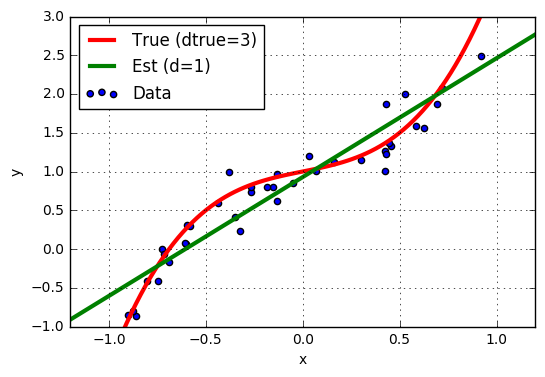

In [7]:
d = 1
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1,1)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=1)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()


What we see is called *underfitting*.  The estimated function is not able to capture the full complexity of the relation between $x$ and $y$.  

Now suppose that we tried a model that was very high, say $d=10$.

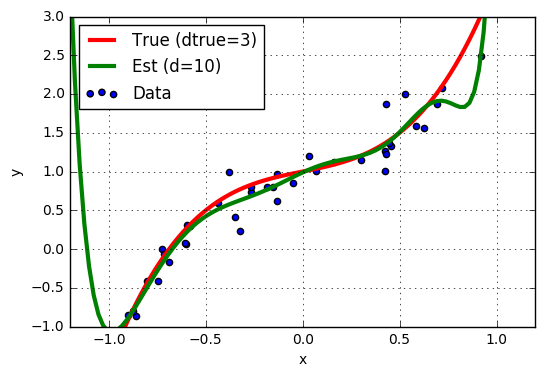

In [8]:
d = 10
beta_hat = poly.polyfit(xdat,ydat,d)

# Plot true and estimated function
xp = np.linspace(-1.2,1.2,100)
yp = poly.polyval(xp,beta)
yp_hat = poly.polyval(xp,beta_hat)
plt.xlim(-1.2,1.2)
plt.ylim(-1,3)
plt.plot(xp,yp,'r-',linewidth=3)
plt.plot(xp,yp_hat,'g-',linewidth=3)

# Plot data
plt.scatter(xdat,ydat)
plt.legend(['True (dtrue=3)', 'Est (d=10)', 'Data'],loc='upper left')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-1.2,1.2])
plt.show()

This is called *overfitting* and results is fitting the noise in the data and not the underlying relation $y=f(x)$.

When we compare the estimated function with the true function we can see the overfitting and underfittnig clearly.  But, in a real problem, we would not have access to the true function (otherwise, we wouldn't need to be estimating it).  The question then is if we can determine the correct model order from data.  

One (bad) idea is for each model order to  measure the RSS on the training data and select $d$ that minimizes the RSS.

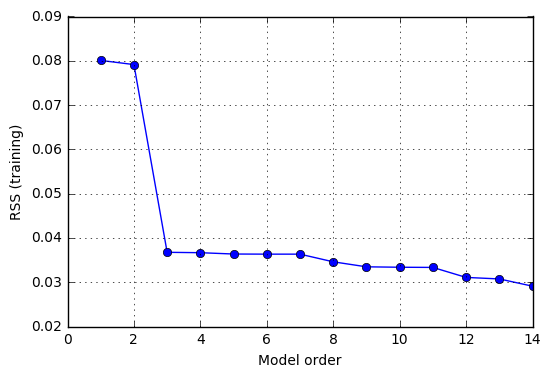

In [9]:
dtest = np.array(range(1,15))
RSStr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xdat,ydat,d)
    
    # Measure RSS on training data
    yhat = poly.polyval(xdat,beta_hat)
    RSSd = np.mean((yhat-ydat)**2)
    RSStr.append(RSSd)
    
plt.plot(dtest,RSStr,'o-')
plt.xlabel('Model order')
plt.ylabel('RSS (training)')
plt.grid()
    

We see that minimizing the RSS on the training data doesn't work:  As we increase $d$, the RSS always decreases.  So minimizing RSS on the training data leads to selecting a very high $d$ which in turn results in over-fitting.  How do we avoid this?



## Using Cross-Validation

To evaluate the model order properly, we need to evaluate the model on samples that were not used in training.  For this reason, we split the data into two components: (1) training and (2) test.  For now, let us split the data equally between the two parts.

In [10]:
# Number of samples for training and test
ntr = nsamp // 2
nts = nsamp - ntr

# Training
xtr = xdat[:ntr]
ytr = ydat[:ntr]

# Test
xts = xdat[ntr:]
yts = ydat[ntr:]

Before we fit the data, let's plot the training and test samples separately.

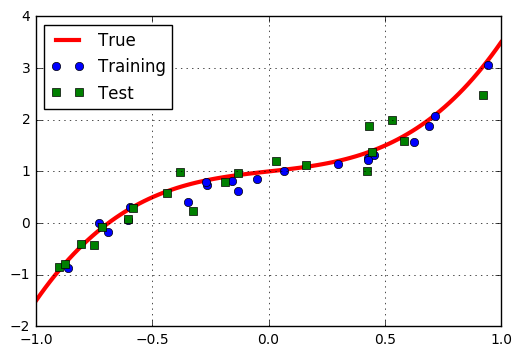

In [11]:
# Plot true function
xp = np.linspace(-1,1,100)
yp = poly.polyval(xp,beta)
plt.xlim(-1,1)
plt.plot(xp,yp,'r-',linewidth=3)

# Plot data
plt.plot(xtr,ytr,'bo')
plt.plot(xts,yts,'gs')
plt.grid()
plt.legend(['True','Training','Test'],loc='upper left')

Now we perform *cross-validation*:  For each model order $d$, we:

* Learn parameters $\hat{\beta}$ of order $d$ on the training data
* Predict the values on the test data
* Measure $RSS_{test}(d)$, the prediction error on the test data.

Select $d$ that minimizes $RSS_{test}(d)$.

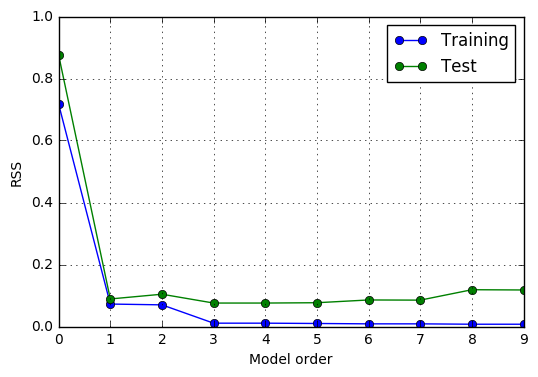

In [12]:
dtest = np.array(range(0,10))
RSStest = []
RSStr = []
for d in dtest:
    
    # Fit data
    beta_hat = poly.polyfit(xtr,ytr,d)
    
    # Measure RSS on training data
    # This is not necessary, but we do it just to show the training error
    yhat = poly.polyval(xtr,beta_hat)
    RSSd = np.mean((yhat-ytr)**2)
    RSStr.append(RSSd)
    
    # Measure RSS on test data
    yhat = poly.polyval(xts,beta_hat)
    RSSd = np.mean((yhat-yts)**2)
    RSStest.append(RSSd)
    
plt.plot(dtest,RSStr,'bo-')
plt.plot(dtest,RSStest,'go-')
plt.xlabel('Model order')
plt.ylabel('RSS')
plt.grid()
plt.ylim(0,1)
plt.legend(['Training','Test'],loc='upper right')
    

We select the model order from the minimum RSS on the test data

In [13]:
imin = np.argmin(RSStest)
print("Estimated model order= {0:d}".format(dtest[imin]))


Estimated model order= 3


## K-Fold Validation

We see that two problems with the simple training / test split in the past example.
* We were only able to use a small number of samples (20 out of 40) for training the model
* The particular model and model order selection depends heavily on the particular samples you chose for the training.

Both of these issues are particularly problematic for data sets with small numbers of samples.  An improvement is to use k-fold validation.  In k-fold validation, we split the data into $k$ parts, each part being approximately equal in size.  In the example below, we will use $k=20$.  For each split, we fit the data on $k-1$ parts and test the data on the remaining part. Then, we average the score over the $k$ parts.  

The `sklearn` package has many routines for this purpose.  We begin by importing the `model_selection` sub-package.

In [14]:
import  sklearn.model_selection 

Then, we run the model validation.  Note that $k$-fold validation can be computationally expensive since we need to iterate over all the folds, and for each fold, we need to iterate over all the model orders.

In [20]:
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(0,10)
nd = len(dtest)

# Loop over the folds
RSSts = np.zeros((nd,nfold))
for isplit, Ind in enumerate(kf.split(xdat)):
        
    # Get the training data in the split
    Itr, Its = Ind
    xtr = xdat[Itr]
    ytr = ydat[Itr]
    xts = xdat[Its]
    yts = ydat[Its]
    
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        beta_hat = poly.polyfit(xtr,ytr,d)
        
        # Measure RSS on test data
        yhat = poly.polyval(xts,beta_hat)
        RSSts[it,isplit] = np.mean((yhat-yts)**2)


Now, we compute the mean and standard error of the RSS over the folds for each model order.  The standard error is defined the standard deviation / $\sqrt{K}$, where $K$ is the number of folds.  The normalization by $\sqrt{K}$ is explained in the text.

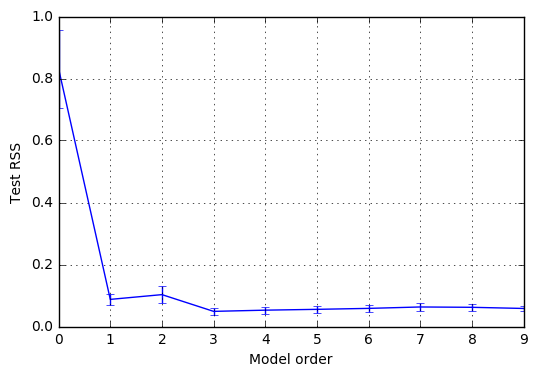

In [21]:
RSS_mean = np.mean(RSSts,axis=1)
RSS_std  = np.std(RSSts,axis=1) / np.sqrt(nfold)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='-')
plt.ylim(0,1)
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

Given these result, one method to select the model order is to use the model order that achieves the minimum mean RSS.  

In [22]:
imin = np.argmin(RSS_mean)
print("The selected model order is {0:d}".format(dtest[imin]))

The selected model order is 3


While this method may work in this data set, it sometimes selects a model order that is too high due to variance in the data.  A more conversative approach is the "one standard deviation" rule:
* Find the model order with the smallest `RSS_mean`
* Set `RSS_tgt` = minimum `RSS_mean` + one std error of the RSS at that minimum
* Find the lowest model order with `RSS < RSS_tgt`

This is illustrated in the following plot.

The estimated model order is 3


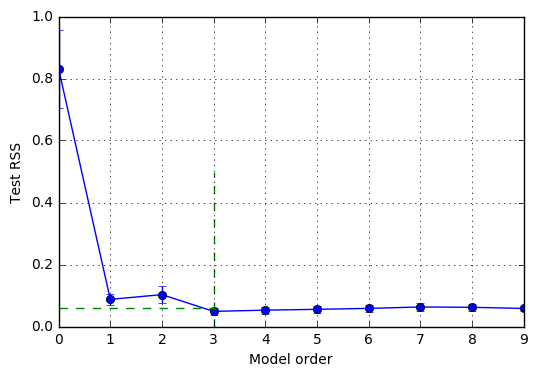

In [23]:
# Find the minimum RSS target
imin = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[imin] + RSS_std[imin]

# Find the lowest model order below the target
I = np.where(RSS_mean <= RSS_tgt)[0]
iopt = I[0]
dopt = dtest[iopt]

plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='o-')

# Plot the line at the RSS target
plt.plot([dtest[0],dtest[imin]], [RSS_tgt, RSS_tgt], '--')

# Plot the line at the optimal model order
plt.plot([dopt,dopt], [0,0.5], 'g--')

plt.ylim(0,1)
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

# Print results
print("The estimated model order is %d" % dopt)